# Only display the necessary steps of the retrieval
### this can be used e.g. to find well matched spectra

In [1]:
from PSDretrieval import processRadar as pR
from PSDretrieval import plotting as pl
from PSDretrieval import scattering as sc
from PSDretrieval import retrievalUtils as rU
import snowScatt
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

load file:/data/obs/campaigns/tripex-pol/processed/
merging datasets done
load file:/data/obs/campaigns/tripex-pol/spectralPeaks/
TODO: this lines should be checked with a time period with two peaks
plot average DV vs DWR for a time-height window


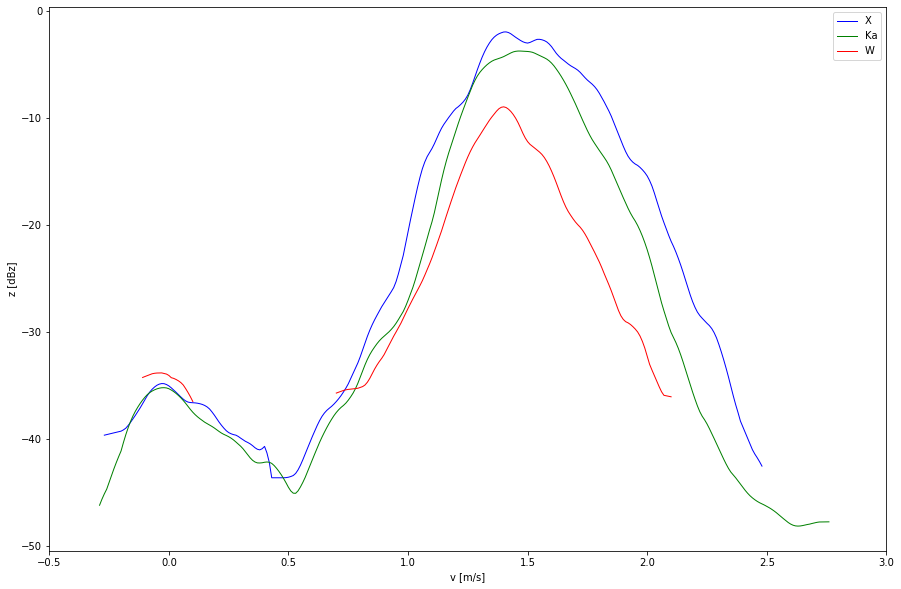

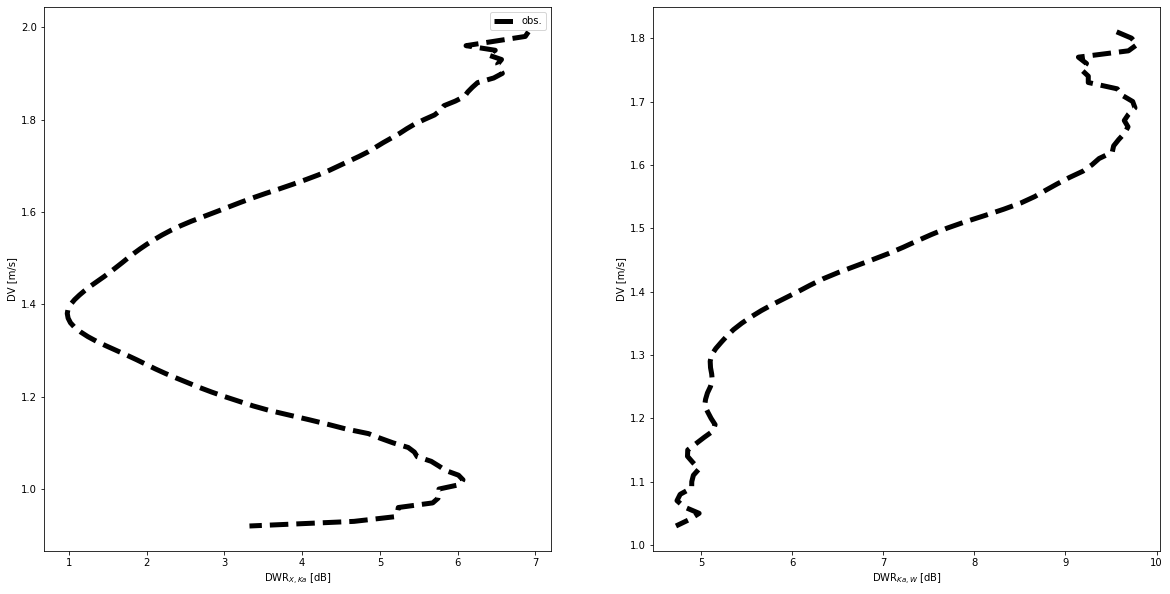

In [4]:
##load data
#define time
date = "20190113"
time = "06:57:24"
hcenter=2000 #[m]
#load data (this is a window of time and height, which can define by additional input parameters)
SpecWindow  = pR.loadSpectra(loadSample=False,dataPath="/data/obs/campaigns/tripex-pol/processed/",createSample=True,date=date,time=time,tRange=1,hRange=180,hcenter=hcenter)
#load the Spectral Window
PeaksWindow  = pR.loadPeaks(loadSample=False,dataPath="/data/obs/campaigns/tripex-pol/spectralPeaks/",createSample=True,date=date,time=time,tRange=1,hRange=180,hcenter=hcenter)
#load the single spectra
SpecSingle  = pR.selectSingleTimeHeight(SpecWindow)

##get vertical wind information from the Spectral data
SpecWindow = pR.addVerticalWindToSpecWindow(SpecWindow,PeaksWindow)
SpecSingle  = pR.selectSingleTimeHeight(SpecWindow)
SpecSingleWshifted  = pR.shiftSpectra(SpecSingle)

##plot spectra
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(15,10))
ax = pl.plotObsSpectra(SpecSingleWshifted,ax)

##find best fitting particle type
#get names of all particle types
ParticleTypesList    = [*snowScatt.snowLibrary._fileList.keys()] #read https://www.python.org/dev/peps/pep-0448/ for the [*...] formalism
#ParticleTypesList   = ["vonTerzi_mixcoldend","vonTerzi_mixcoldend_rimed05"]
#find best fitting particle type
#[bestPartType,orderedListPartType] = rU.findBestFittingPartType(ParticleTypesList,SpecWindow)

##plot sDWR vs DV for best fitting particle type
fig2,axes2 = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
SpecWindow = pR.cutLowZe(SpecWindow,zeThreshold=-20)
__ = pl.plotSDWRvsDVobs(SpecWindow,axes2)
#calculate single-particle properties from snowScatt model
#Zx, Zk, Zw, Dmax, K2, vel = sc.model3fOne(bestPartType)
#DWRxk = Zx - Zk; DWRkw = Zk - Zw
#axes2 = pl.plotSDWRvsDVmodel(vel,DWRxk,DWRkw,axes2,bestPartType)

DmaxRetr 3.0 DmaxAtDWRmax 2.990395197598799 DWRmin --


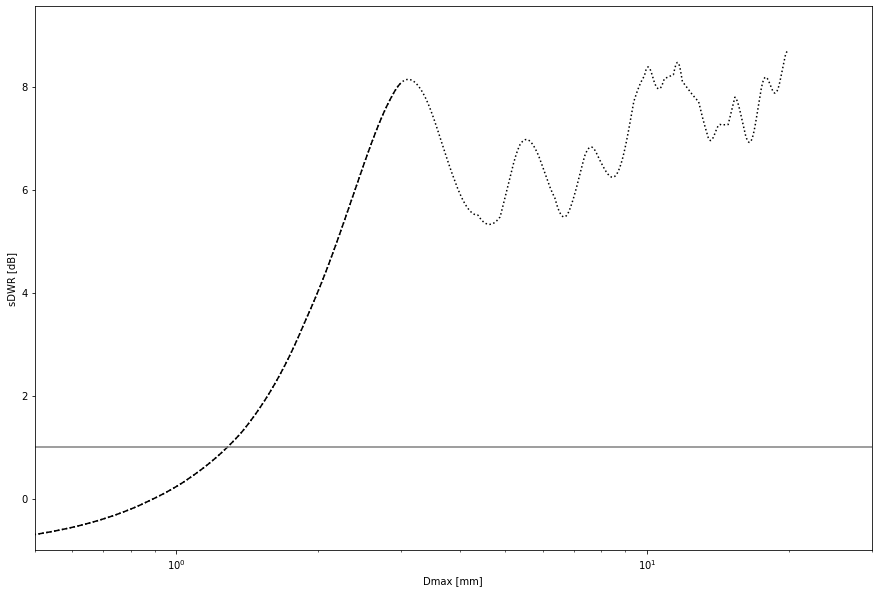

In [17]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(15,10))
Zx, Zk, Zw, Dmax, K2, vel = sc.model3fOne("vonTerzi_column")
DWRxk = Zx - Zk; DWRkw = Zk - Zw
DWRUnamb,ax = sc.getUnambigousDWRdmax(Dmax,DWRkw,DmaxRetr=3e-3,showIllus=True,ax=ax) #get Unambiguous DWR-Dmax relation